## test model


In [99]:
import torch
import cv2
from transformers import Swinv2ForImageClassification
from transformers.image_transforms import to_channel_dimension_format

In [7]:
model = Swinv2ForImageClassification.from_pretrained("./tagger-hf")

In [1]:
from PIL import Image

In [47]:
image = Image.open("sample.jpg")

In [68]:
import numpy as np

In [73]:
# ref: https://huggingface.co/spaces/SmilingWolf/wd-v1-4-tags/blob/main/app.py#L124
def set_white_bg(img: Image.Image):
    img = img.convert("RGBA")
    white_bg = Image.new("RGBA", img.size, "WHITE")
    white_bg.paste(img, mask=img)
    return white_bg.convert("RGB")

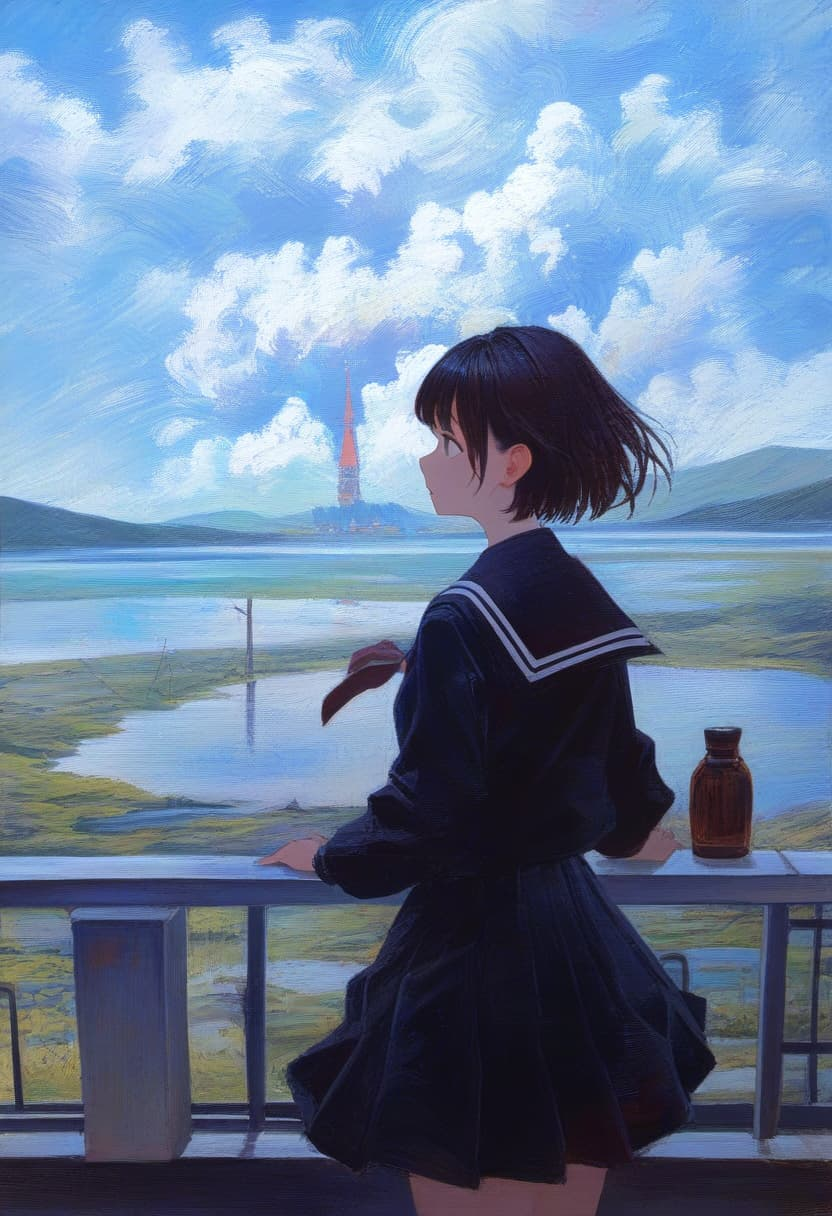

In [75]:
image = set_white_bg(image)
image

In [117]:
# ref: https://huggingface.co/spaces/SmilingWolf/wd-v1-4-tags/blob/main/app.py#L130
def preprocess(img: Image.Image, size: int):
    img = np.asarray(img)

    # PIL RGB to OpenCV BGR
    img = img[:, :, ::-1]

    old_size = img.shape[:2]
    desired_size = max(old_size)
    desired_size = max(desired_size, size)

    delta_w = desired_size - old_size[1]
    delta_h = desired_size - old_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [255, 255, 255]
    img = cv2.copyMakeBorder(
        img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

    if img.shape[0] > size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
    elif img.shape[0] < size:
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_CUBIC)

    # PIL RGB to OpenCV BGR
    img = img[:, :, ::-1]
    img = img.astype(np.float32)
    img = to_channel_dimension_format(img, "channels_first")
    img = np.expand_dims(img, 0)

    return img

preprocess(image, 448)

array([[[[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],

        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],

        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]]]], dtype=float32)

In [118]:
inputs = {
    "pixel_values": torch.tensor(preprocess(image, 448))
}
inputs["pixel_values"].shape

torch.Size([1, 3, 448, 448])

In [119]:
with torch.no_grad():
    outputs = model(**inputs)

In [120]:
outputs

Swinv2ImageClassifierOutput(loss=None, logits=tensor([[ 2.5977,  2.1429,  1.0809,  ...,  0.1250, -3.7694, -4.0537]]), hidden_states=None, attentions=None, reshaped_hidden_states=None)

In [121]:
logits = torch.sigmoid(outputs.logits[0])

In [127]:
results = {
   model.config.id2label[i]: logit.float() for i, logit in enumerate(logits)
}
results # rating tags and character tags are also included

{'general': tensor(0.9307),
 'sensitive': tensor(0.8950),
 'questionable': tensor(0.7467),
 'explicit': tensor(0.4785),
 '1girl': tensor(0.0069),
 'solo': tensor(0.8525),
 'long_hair': tensor(0.8491),
 'breasts': tensor(0.2737),
 'looking_at_viewer': tensor(0.0825),
 'blush': tensor(0.1923),
 'smile': tensor(0.0352),
 'short_hair': tensor(0.9848),
 'open_mouth': tensor(0.6551),
 'bangs': tensor(0.5489),
 'blue_eyes': tensor(0.3792),
 'multiple_girls': tensor(0.9365),
 'skirt': tensor(0.8974),
 'blonde_hair': tensor(0.1064),
 'large_breasts': tensor(0.9262),
 'simple_background': tensor(0.2395),
 'brown_hair': tensor(0.7583),
 'shirt': tensor(0.9509),
 'black_hair': tensor(0.0196),
 'hair_ornament': tensor(0.0328),
 'red_eyes': tensor(0.9417),
 'thighhighs': tensor(0.0899),
 'gloves': tensor(0.2241),
 'long_sleeves': tensor(0.0239),
 '1boy': tensor(0.6709),
 'hat': tensor(0.1104),
 'white_background': tensor(0.0371),
 'dress': tensor(0.9253),
 'bow': tensor(0.5081),
 'ribbon': tensor(0.

In [131]:
results = {k:v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
results # 🤔???

{'green_hair': tensor(1.0000),
 'suzuya_(kancolle)': tensor(1.0000),
 'belfast_(azur_lane)': tensor(1.0000),
 'sirius_(azur_lane)': tensor(1.0000),
 'osaki_amana': tensor(1.0000),
 'buruma_pull': tensor(1.0000),
 'enkidu_(fate)': tensor(1.0000),
 'sleeveless_coat': tensor(1.0000),
 'extra': tensor(1.0000),
 'folding_chair': tensor(1.0000),
 'print_headwear': tensor(1.0000),
 'cleaver': tensor(1.0000),
 'fujimaru_ritsuka_(male)': tensor(0.9999),
 'maid_headdress': tensor(0.9999),
 'rod_of_remorse': tensor(0.9998),
 'lace-trimmed_skirt': tensor(0.9998),
 'folded_fan': tensor(0.9998),
 'sonoda_chiyoko': tensor(0.9998),
 'weightlifting': tensor(0.9998),
 'cropped_torso': tensor(0.9998),
 'tube': tensor(0.9998),
 'polar_bear': tensor(0.9997),
 'wrist_bow': tensor(0.9997),
 'buruma_aside': tensor(0.9996),
 'bandaid_on_pussy': tensor(0.9996),
 'kobayakawa_sae': tensor(0.9996),
 'black_tank_top': tensor(0.9996),
 'microphone': tensor(0.9996),
 'brown_belt': tensor(0.9995),
 'dynamax_band': ten